In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
import cv2
import torch
import urllib.request
from cartoonX_segment import CartoonX
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [ ]:
!pip install grad-cam

## Load the image

In [3]:

image = np.array(Image.open('cow.jpg'))
rgb_img = np.float32(image) / 255
input_tensor =  transforms.ToTensor()(rgb_img)
input_tensor=transforms.Resize(size=(256,256))(input_tensor).unsqueeze(0)

print(input_tensor.shape)
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.to('cuda:0')
    input_tensor = input_tensor.to('cuda:0')

output = model(input_tensor)
print(type(output), output.keys())

torch.Size([1, 3, 256, 256])
<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [4]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

In [5]:

res = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

## Specify Category of interest

In [6]:
category_to_select="car"

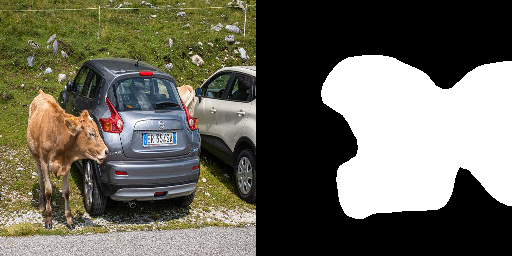

In [7]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx[category_to_select]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((res[0:256,0:256,:], np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

In [8]:
# set CartoonX hyperparameters
pred = model(input_tensor)
pred=torch.argmax(pred,1,keepdim=True)
device='cuda:0'
HPARAMS ={"wave": "db3", "mode": "zero", "J": 5,
          "l1lambda": 2, "step_size": 1e-2,
          "num_steps": 1000,  "batch_size": 4,
          "distortion_measure": "label","return_mask":True} 

# get Cartoon RDE 
cartoonX = CartoonX(model=model, device=device, **HPARAMS)
explanation,mask = cartoonX(input_tensor, pred,torch.tensor(car_mask_float).unsqueeze(0).unsqueeze(0).to(device))

 iter 999

## Explanation Mask

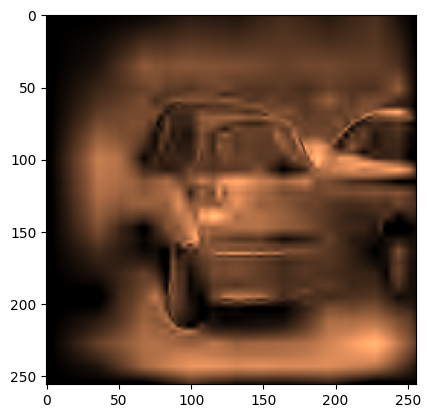

In [9]:
plt.imshow(explanation.permute(1,2,0).cpu(),cmap='copper')

img=explanation.permute(1,2,0).cpu()[:,:,0].numpy()
zz = cv2.resize(img, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
# print(zz.shape)
# plt.imsave('car_focus.png', zz,cmap='copper')